In [1]:
%load_ext nb_black

import os
import sys

sys.path.append(
    os.path.abspath("/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/codebase")
)
import torch.backends.cudnn as cudnn
import random
import time
from collections import OrderedDict
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.functional import one_hot
import sklearn.metrics as metrics
import utils
from Explainer.loss_F import loss_fn_kd, entropy_loss
from Explainer.models.Gated_Logic_Net import Gated_Logic_Net
from Explainer.models.explainer import Explainer
from Explainer.models.pi import Pi
from dataset.dataset_cubs import Dataset_cub_for_explainer
from dataset.utils_dataset import get_dataset_with_image_and_attributes
from Explainer.loss_F import loss_fn_kd, entropy_loss, Selective_Distillation_Loss
from Explainer.models.concepts import Conceptizator
import Plots.plot_for_paper as plot
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
device = utils.get_device()
print(f"Device: {device}")

Device: cuda


<IPython.core.display.Javascript object>

In [ ]:
lr = 0.001
cov = 0.4
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ResNet50/lr_{lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.4_lr_0.001",
        "iter3",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr)
print(args.cov)

In [ ]:
print(args.arch)
print(args.layer)

print(args.checkpoint_model)
print(args.checkpoint_residual)

print(args.iter)

In [ ]:
use_concepts_as_pi_input = True
explainer_init = "none"
cov = args.cov[0]
experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{cov}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

print(experiment_folder)

In [ ]:
lr = 0.001
cov = 0.4
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ResNet101/lr_{lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "iter1",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr)
print(args.cov)

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter1"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_1 = torch.load(
    os.path.join(
        root, experiment, iteration, expert_type, output, "test_tensor_preds.pt"
    )
)

test_tensor_preds_bb_1 = torch.load(
    os.path.join(
        root, experiment, iteration, expert_type, output, "test_tensor_preds_bb.pt"
    )
)

test_tensor_y_1 = torch.load(
    os.path.join(root, experiment, iteration, expert_type, output, "test_tensor_y.pt")
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_1.size())
print(test_tensor_preds_bb_1.size())
print(test_tensor_y_1.size())

In [ ]:
base_lr = 0.001
base_cov = 0.4
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.4_lr_0.001",
        "iter2",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter2"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.4_lr_0.001",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.4_lr_0.001",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.4_lr_0.001",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_2.size())
print(test_tensor_preds_bb_2.size())
print(test_tensor_y_2.size())


In [ ]:
base_lr = 0.001
base_cov = 0.4
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.4_lr_0.001",
        "iter3",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter3"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.4_lr_0.001",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.4_lr_0.001",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.4_lr_0.001",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_3.size())
print(test_tensor_preds_bb_3.size())
print(test_tensor_y_3.size())


In [9]:
base_lr = 0.001
base_cov = 0.4
pickle_in = open(
    os.path.join(
        f"/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ResNet101/lr_{base_lr}_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_{base_cov}_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none",
        "cov_0.4_lr_0.001",
        "iter4",
        "explainer",
        "test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/"
experiment = f"explainer/ResNet101/{experiment_folder}"
iteration = "iter4"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.4_lr_0.001",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.4_lr_0.001",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.4_lr_0.001",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_4.size())
print(test_tensor_preds_bb_4.size())
print(test_tensor_y_4.size())


########################
0.001
0.4


 << Test sizes >>
torch.Size([643, 50])
torch.Size([643, 50])
torch.Size([643])


<IPython.core.display.Javascript object>

In [10]:
expert_type = "explainer"
output = "g_outputs"

preds = torch.cat((test_tensor_preds_1, test_tensor_preds_2, test_tensor_preds_3, 
                   test_tensor_preds_4, 
#                    test_tensor_preds_5, test_tensor_preds_6, 
#                    test_tensor_preds_7,  
#                    test_tensor_preds_8
                  ), dim=0)
gt = torch.cat((
    test_tensor_y_1, test_tensor_y_2, test_tensor_y_3 ,
    test_tensor_y_4, 
#     test_tensor_y_5, test_tensor_y_6,
#                test_tensor_y_7, 
#     test_tensor_y_8
               ),
               dim=0)
bb = torch.cat((
    test_tensor_preds_bb_1.cpu(), test_tensor_preds_bb_2.cpu(), test_tensor_preds_bb_3.cpu(),
    test_tensor_preds_bb_4.cpu(), 
#     test_tensor_preds_bb_5.cpu(), test_tensor_preds_bb_6.cpu(), 
#     test_tensor_preds_bb_7.cpu(),
#     test_tensor_preds_bb_8.cpu()
), 
               dim=0)


<IPython.core.display.Javascript object>

In [11]:
torch.sum(preds.argmax(dim=1) == gt) / gt.size(0), gt.size()

(tensor(0.8539), torch.Size([6634]))

<IPython.core.display.Javascript object>

In [12]:
preds_tot_np = preds.argmax(dim=1).numpy()
gt_tot_np = gt.numpy()
bb_tot_np = bb.argmax(dim=1).numpy()
bb_tot_acc = metrics.accuracy_score(gt_tot_np, bb_tot_np)
g_tot_acc = metrics.accuracy_score(gt_tot_np, preds_tot_np)
g_tot_f1 = metrics.f1_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_precision = metrics.precision_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_recall = metrics.recall_score(gt_tot_np, preds_tot_np, average="micro")
bb_tot_recall = metrics.recall_score(gt_tot_np, bb_tot_np, average="micro")
g_tot_cov = preds.size(0) / 7465


print(f"g_tot_acc: {g_tot_acc * 100} (%)")
print(f"bb_tot_acc: {bb_tot_acc * 100} (%)")
print(f"g_tot_f1: {g_tot_f1 * 100} (%)")
print(f"g_tot_precision: {g_tot_precision * 100} (%)")
print(f"g_tot_recall: {g_tot_recall * 100} (%)")
print(f"bb_tot_recall: {bb_tot_recall * 100} (%)")
print(f"total samples covered by g: {preds.size(0)} (out of {7465})")
print(f"total coverage by g: {g_tot_cov}")

g_tot_acc: 85.39342779620138 (%)
bb_tot_acc: 91.82996683750378 (%)
g_tot_f1: 85.39342779620138 (%)
g_tot_precision: 85.39342779620138 (%)
g_tot_recall: 85.39342779620138 (%)
bb_tot_recall: 91.82996683750378 (%)
total samples covered by g: 6634 (out of 7465)
total coverage by g: 0.8886805090421969


<IPython.core.display.Javascript object>

In [13]:
test_tensor_preds_residual = torch.load(
    os.path.join(
        "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ResNet101/lr_0.001_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.4_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.4_lr_0.001/iter4/bb/residual_outputs",
        "test_tensor_preds_residual.pt",
    )
)

test_tensor_preds_bb_residual = torch.load(
    os.path.join(
        "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ResNet101/lr_0.001_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.4_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.4_lr_0.001/iter4/bb/residual_outputs",
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_residual = torch.load(
    os.path.join(
        "/ocean/projects/asc170022p/shg121/PhD/ICLR-2022/out/awa2/explainer/ResNet101/lr_0.001_epochs_500_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.4_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.4_lr_0.001/iter4/bb/residual_outputs",
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_residual.size())
print(test_tensor_preds_bb_residual.size())
print(test_tensor_y_residual.size())




 << Test sizes >>
torch.Size([831, 50])
torch.Size([831, 50])
torch.Size([831])


<IPython.core.display.Javascript object>

In [15]:
torch.sum(
    test_tensor_preds_residual.argmax(dim=1) == test_tensor_y_residual
) / test_tensor_preds_residual.size(0)

tensor(0.7196)

<IPython.core.display.Javascript object>

In [18]:
expert_type = "explainer"
output = "g_outputs"

preds = torch.cat((test_tensor_preds_1, test_tensor_preds_2, test_tensor_preds_3, 
                   test_tensor_preds_4, 
                     test_tensor_preds_residual,
#                    test_tensor_preds_7, test_tensor_preds_8
                  ), dim=0)
gt = torch.cat((test_tensor_y_1, test_tensor_y_2, test_tensor_y_3 ,
                test_tensor_y_4, 
                test_tensor_y_residual
#                test_tensor_y_7, test_tensor_y_8
               ), dim=0)
bb = torch.cat((
    test_tensor_preds_bb_1.cpu(), test_tensor_preds_bb_2.cpu(), test_tensor_preds_bb_3.cpu(),
    test_tensor_preds_bb_4.cpu(),
    test_tensor_preds_bb_residual.cpu()
#     test_tensor_preds_bb_7.cpu(), test_tensor_preds_bb_8.cpu()
), 
               dim=0)

preds_tot_np = preds.argmax(dim=1).numpy()
gt_tot_np = gt.numpy()
bb_tot_np = bb.argmax(dim=1).numpy()
bb_tot_acc = metrics.accuracy_score(gt_tot_np, bb_tot_np)
g_tot_acc = metrics.accuracy_score(gt_tot_np, preds_tot_np)
g_tot_f1 = metrics.f1_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_precision = metrics.precision_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_recall = metrics.recall_score(gt_tot_np, preds_tot_np, average="micro")
bb_tot_recall = metrics.recall_score(gt_tot_np, bb_tot_np, average="micro")
g_tot_cov = preds.size(0) / 7465


print(f"g_tot_acc: {g_tot_acc * 100} (%)")
print(f"bb_tot_acc: {bb_tot_acc * 100} (%)")
print(f"g_tot_f1: {g_tot_f1 * 100} (%)")
print(f"g_tot_precision: {g_tot_precision * 100} (%)")
print(f"g_tot_recall: {g_tot_recall * 100} (%)")
print(f"bb_tot_recall: {bb_tot_recall * 100} (%)")
print(f"total samples covered by g: {preds.size(0)} (out of {7465})")
print(f"total coverage by g: {g_tot_cov}")


g_tot_acc: 83.89819156061621 (%)
bb_tot_acc: 91.69457468184862 (%)
g_tot_f1: 83.89819156061621 (%)
g_tot_precision: 83.89819156061621 (%)
g_tot_recall: 83.89819156061621 (%)
bb_tot_recall: 91.69457468184862 (%)
total samples covered by g: 7465 (out of 7465)
total coverage by g: 1.0


<IPython.core.display.Javascript object>

In [48]:
(0.3022103116405305+
 0.2321902284331555+
 0.1832953830238005+
 0.07117883688478923+
 0.08010716691403603)


0.8689819268963117

<IPython.core.display.Javascript object>

In [39]:
(
    (
        torch.sum(test_tensor_preds_1.argmax(dim=1) == test_tensor_y_1)
        / test_tensor_y_1.size(0)
    ).item()
    * (test_tensor_preds_1.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_2.argmax(dim=1) == test_tensor_y_2)
        / test_tensor_y_2.size(0)
    ).item()
    * (test_tensor_preds_2.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_3.argmax(dim=1) == test_tensor_y_3)
        / test_tensor_y_3.size(0)
    ).item()
    * (test_tensor_preds_3.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_4.argmax(dim=1) == test_tensor_y_4)
        / test_tensor_y_4.size(0)
    ).item()
    * (test_tensor_preds_4.size(0) / 7465),
    (
        torch.sum(test_tensor_preds_residual.argmax(dim=1) == test_tensor_y_residual)
        / test_tensor_preds_residual.size(0)
    ).item()
    * (test_tensor_preds_residual.size(0) / 7465),
)

(0.3022103116405305,
 0.2121902284331555,
 0.1632953830238005,
 0.08117883688478923,
 0.08010716691403603)

<IPython.core.display.Javascript object>

In [40]:
(
    (
        torch.sum(test_tensor_preds_1.argmax(dim=1) == test_tensor_y_1)
        / test_tensor_y_1.size(0)
    ).item(),
    (
        torch.sum(test_tensor_preds_2.argmax(dim=1) == test_tensor_y_2)
        / test_tensor_y_2.size(0)
    ).item(),
    (
        torch.sum(test_tensor_preds_3.argmax(dim=1) == test_tensor_y_3)
        / test_tensor_y_3.size(0)
    ).item(),
    (
        torch.sum(test_tensor_preds_4.argmax(dim=1) == test_tensor_y_4)
        / test_tensor_y_4.size(0)
    ).item(),
    (
        torch.sum(test_tensor_preds_residual.argmax(dim=1) == test_tensor_y_residual)
        / test_tensor_preds_residual.size(0)
    ).item(),
)

(0.8433644771575928,
 0.8457021117210388,
 0.8447678685188293,
 0.9424572587013245,
 0.7196149230003357)

<IPython.core.display.Javascript object>

In [41]:
(
    test_tensor_preds_1.size(0) / 7465,
    test_tensor_preds_2.size(0) / 7465,
    test_tensor_preds_3.size(0) / 7465,
    test_tensor_preds_4.size(0) / 7465,
    test_tensor_preds_residual.size(0) / 7465,
)

(0.3583389149363697,
 0.2509042196918955,
 0.19330207635632954,
 0.08613529805760214,
 0.11131949095780308)

<IPython.core.display.Javascript object>

In [42]:
0.7196149230003357 * 0.11131949095780308

0.08010716691403603

<IPython.core.display.Javascript object>

In [32]:
expert_1_gt, expert_1_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_1, pred_tensor=test_tensor_preds_1, n_classes=50
)

expert_2_gt, expert_2_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_2, pred_tensor=test_tensor_preds_2, n_classes=50
)
expert_3_gt, expert_3_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_3, pred_tensor=test_tensor_preds_3, n_classes=50
)
expert_4_gt, expert_4_correct_pred = plot.create_data_for_expert_label_plot(
    GT_tensor=test_tensor_y_4, pred_tensor=test_tensor_preds_4, n_classes=50
)
# expert_5_gt, expert_5_correct_pred = plot.create_data_for_expert_label_plot(
#     GT_tensor=test_tensor_y_5, pred_tensor=test_tensor_preds_5, n_classes=50
# )
# expert_6_gt, expert_6_correct_pred = plot.create_data_for_expert_label_plot(
#     GT_tensor=test_tensor_y_6, pred_tensor=test_tensor_preds_6, n_classes=50
# )
# expert_7_gt, expert_7_correct_pred = plot.create_data_for_expert_label_plot(
#     GT_tensor=test_tensor_y_7, pred_tensor=test_tensor_preds_7, n_classes=200
# )
# expert_8_gt, expert_8_correct_pred = plot.create_data_for_expert_label_plot(
#     GT_tensor=test_tensor_y_8, pred_tensor=test_tensor_preds_8, n_classes=200
# )


expert_1_gt =np.array([expert_1_gt]).T
expert_2_gt =np.array([expert_2_gt]).T
expert_3_gt =np.array([expert_3_gt]).T
expert_4_gt =np.array([expert_4_gt]).T
# expert_5_gt =np.array([expert_5_gt]).T
# expert_6_gt =np.array([expert_6_gt]).T
# expert_7_gt =np.array([expert_7_gt]).T
# expert_8_gt =np.array([expert_8_gt]).T

expert_gt = np.concatenate(
    (
        expert_1_gt, 
        expert_2_gt,
        expert_3_gt,
        expert_4_gt,
#         expert_5_gt,
#         expert_6_gt,
#         expert_7_gt,
#         expert_8_gt
    ), axis=1)

expert_1_correct_pred =np.array([expert_1_correct_pred]).T
expert_2_correct_pred =np.array([expert_2_correct_pred]).T
expert_3_correct_pred =np.array([expert_3_correct_pred]).T
expert_4_correct_pred =np.array([expert_4_correct_pred]).T
# expert_5_correct_pred =np.array([expert_5_correct_pred]).T
# expert_6_correct_pred =np.array([expert_6_correct_pred]).T
# expert_7_correct_pred =np.array([expert_7_correct_pred]).T
# expert_8_correct_pred =np.array([expert_8_correct_pred]).T

expert_correct_preds = np.concatenate(
    (
        expert_1_correct_pred, 
        expert_2_correct_pred,
        expert_3_correct_pred,
        expert_4_correct_pred,
#         expert_5_correct_pred,
#         expert_6_correct_pred,
#         expert_7_correct_pred,
#         expert_8_correct_pred
    ), axis=1)
print(expert_gt.shape)
print(expert_correct_preds.shape)






# print(exper_gt.shape)
# print(expert_correct_preds.shape)



(50, 4)
(50, 4)


<IPython.core.display.Javascript object>

In [33]:
order = np.lexsort(
    [
        expert_gt[:, 0],
        expert_gt[:, 1],
        expert_gt[:, 2],
        expert_gt[:, 3],
#         expert_gt[:, 4],
#         expert_gt[:, 5],
#         expert_gt[:, 6],
#         expert_gt[:, 7],
    ]
)
print(order)
print(len(order))
sorted_cols = []
for idx in order:
    sorted_cols.append(args.labels[idx])
# print(args.labels)
# print(sorted_cols)
expert_gt[order]


[37  8 46  2 17 49 36 22 15  4 20 48 11  3 35  0 30 23 41  6 39 34 29 43
 32  9 33  5 40 21 25 28 26  1 10 45 16 42  7 31 14 13 44 47 24 27 19 18
 38 12]
50


array([[  0,   0,   0,   0],
       [ 35,   0,   0,   0],
       [ 43,   0,   0,   0],
       [ 58,   0,   0,   0],
       [142,   0,   0,   0],
       [189,   0,   0,   0],
       [158,  10,   0,   0],
       [252,  10,   0,   0],
       [101,  37,   0,   0],
       [  2, 104,   0,   0],
       [ 35, 107,   0,   0],
       [ 43, 223,   0,   0],
       [ 13,   0,   1,   0],
       [ 16,   0,   1,   0],
       [ 78,   0,   1,   0],
       [  5, 202,   1,   0],
       [  0, 239,   1,   0],
       [194,   0,   2,   0],
       [ 88,  11,   3,   0],
       [286,  40,   3,   0],
       [  4, 262,   3,   0],
       [  3,   3,  11,   0],
       [ 62,   0,  12,   0],
       [  3,   1,  22,   0],
       [  8,  71,  31,   0],
       [ 14,  18,  37,   0],
       [  5,   1,  40,   0],
       [ 17,  17, 112,   0],
       [  2,   7, 113,   0],
       [  1,   3, 118,   0],
       [  2,  15, 126,   0],
       [  1,   2, 209,   0],
       [  2,   0, 234,   0],
       [150,   1,   1,   1],
       [  4,  

<IPython.core.display.Javascript object>

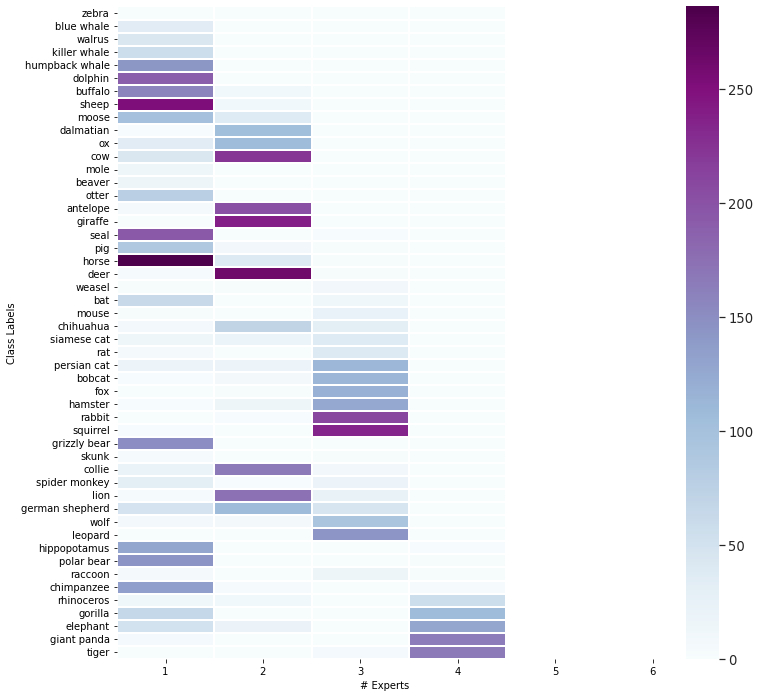

<IPython.core.display.Javascript object>

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# print(y_axis_labels)
y_axis_labels = sorted_cols
for idx, label in enumerate(y_axis_labels):
    y_axis_labels[idx] = label.replace("+", " ")
#     print(idx, label)


x_axis_labels = [1, 2, 3, 4, 5, 6]
# for i in range(1, 201):
#     y_axis_labels.append(i)

fig, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.2)
p = sns.heatmap(
    expert_gt[order],
    xticklabels=x_axis_labels,
    yticklabels=y_axis_labels,
    linewidths=0.1,
    cmap="BuPu",
)
p.set_xlabel("# Experts")
p.set_ylabel("Class Labels")
# p.set_yticklabels(p.get_yticklabels(), rotation=10)
plt.show()

In [21]:
torch.sum(test_tensor_preds_1.argmax(dim=1) == test_tensor_y_1) / test_tensor_y_1.size(
    0
)

tensor(0.8434)

<IPython.core.display.Javascript object>